In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Deep Q learning with Cartpole


## Step 1: Import the libraries 

In [3]:
import random
import gym
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


import warnings 
warnings.filterwarnings('ignore') 

Using TensorFlow backend.


In [4]:
env = gym.make('CartPole-v1')

In [5]:
env.close()

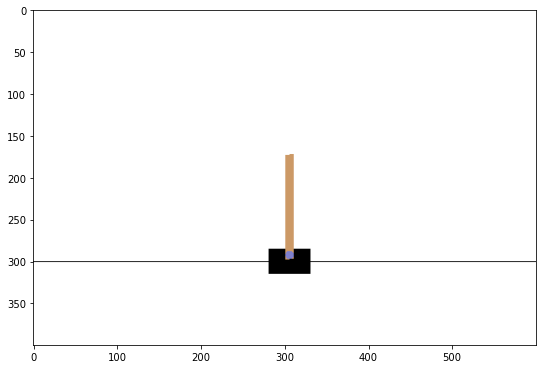

In [6]:
from IPython import display

env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) 
for _ in range(10):
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

Probel Overview:
* A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
* The system is controlled by applying a force of +1 or -1 to the cart. 
* The pendulum starts upright, and the goal is to prevent it from falling over. 
* A reward of +1 is provided for every timestep that the pole remains upright. 
* The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [7]:
action_size = env.action_space.n
action_size

2

In [8]:
state_size = env.observation_space.shape[0]
state_size

4

In [9]:
n_episodes = 1000
bs = 64 # batch Size
output_dir = 'Cartpole/' # Weight Save Location

In [11]:
class DQN:
    def __init__(self, state_size, action_size, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []# list to append
        self.gamma = 0.95 # discount rate
        self.epsilon = 1.0 # initial rate of exploration 
        self.epsilon_decay = 0.997 # amount to decrease exploration
        self.min_epsilon = 0.01 # minimum amount of random exploration
        self.lr = lr # learning rate
        self.count=[]
        self.model = self.Network() # make model 
    
    def store_count_reward(self, e,i): 
        self.count.append([e,i])
    
    def Network(self):
        # Q-value approximation function:
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu')) # 1st hidden layer;  4 states as input
        model.add(Dropout(0.1))
        model.add(Dense(64, activation='relu')) # 2nd hidden layer
        model.add(Dropout(0.1))
        model.add(Dense(128, activation='relu')) # 3rd hidden layer
        model.add(Dropout(0.1))
        model.add(Dense(64, activation='relu')) # 4th hidden layer
        model.add(Dropout(0.1))
        model.add(Dense(self.action_size, activation='linear')) # 2 actions, so 2 output neurons: 0 and 1 (L/R)
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model
    
    def history(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # list of previous experiences for training

    def act(self, state, evalmode=False):        
        if np.random.rand() <= self.epsilon and evalmode==False: # if acting randomly, and not in exploitation mode
            return random.randrange(self.action_size)
        else:
            act_values = self.model.predict(state) # if not acting randomly or in eval mode, predict reward 
            return np.argmax(act_values[0]) # pick the action with max reward (left or right)

    def decrement_epsilon(self):
        if self.epsilon > self.min_epsilon: # decay exploration
            self.epsilon *= self.epsilon_decay
            
    def train(self, bs): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, bs) # sample a minibatch from memory    
        y_batch=[]
        for state, action, reward, next_state, done in minibatch: # get data from each minibatch sample            
            q_target = self.model.predict(state) 
            q_target[0][action] = reward if done else reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            y_batch.append(q_target[0])
        x_batch=np.concatenate(np.array(minibatch)[:,0])
        self.model.fit(x_batch, np.array(y_batch), epochs=1,batch_size=bs, verbose=0) # train mini batch 1 epoch
        self.decrement_epsilon() # decay exploration

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Make Agent

In [12]:
agent = DQN(state_size, action_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
done = False
MAX=0
for e in tqdm(range(n_episodes)): # iterate over new episodes of the game
    state = env.reset() # reset state at start of each new episode of the game
    state = np.reshape(state, [1, state_size])
    
    for i in range(1000):  # step in episode.       
        action = agent.act(state, evalmode=False) # either 0 or 1 (move cart left or right)
        next_state, reward, done, _ = env.step(action) # agent interacts with env, gets feedback; 4 state data points, e.g., pole angle, cart position        
        #reward = reward if not done else -100 # reward +1 for each additional frame with pole upright        
        next_state = np.reshape(next_state, [1, state_size])
        agent.history(state, action, reward, next_state, done) # append to history for retraining of NN      
        state = next_state # reset state      
        if done: break # episode ends if agent drops pole 

    if len(agent.memory) > bs:
        agent.train(bs) # train the agent
    if MAX < i: # Save weights with best score
        MAX=i
        #print(f"episode: {e}/{n_episodes}, \tscore: {i}, \te: {round(agent.epsilon,3)} Saving weights...")
        agent.save(output_dir + f"Best_Weights.hdf5") 

    agent.store_count_reward(e,i)
    
print(f'*** HIGH SCORE: {MAX} ***')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:02<00:00, 15.99it/s]

*** HIGH SCORE: 499 ***


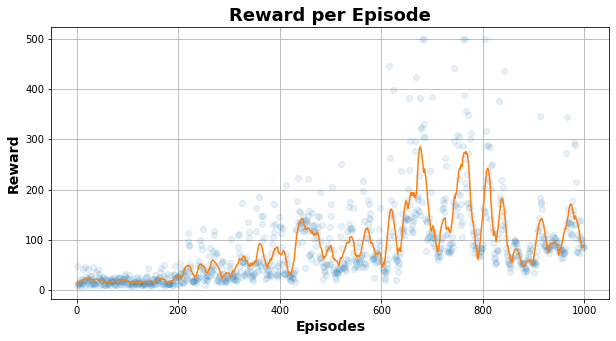

In [19]:
arr=np.array(agent.count)
x=arr[:,0]
y=arr[:,1]
y_trend=savgol_filter(y, 33, 3, mode='nearest')

plt.figure(figsize=(10,5))
plt.plot(x,y, 'o', alpha=0.1)
plt.plot(x,y_trend, '-')
plt.ylabel('Reward',fontsize=14, fontweight='bold')
plt.xlabel('Episodes',fontsize=14, fontweight='bold')
plt.title('Reward per Episode', fontsize=18, fontweight='bold')
plt.grid()
plt.show()

## Drop Learning Rate and continue to learn

In [20]:
agent = DQN(state_size, action_size, lr=0.0001)

In [21]:
agent.load(output_dir + f"Best_Weights.hdf5")

In [22]:
done = False
MAX=0

for e in tqdm(range(n_episodes)): # iterate over new episodes of the game
    state = env.reset() # reset state at start of each new episode of the game
    state = np.reshape(state, [1, state_size])
    
    for i in range(1000):  # step in episode.       
        action = agent.act(state, evalmode=False) # either 0 or 1 (move cart left or right)
        next_state, reward, done, _ = env.step(action) # agent interacts with env, gets feedback; 4 state data points, e.g., pole angle, cart position        
        #reward = reward if not done else -100 # reward +1 for each additional frame with pole upright        
        next_state = np.reshape(next_state, [1, state_size])
        agent.history(state, action, reward, next_state, done) # append to history for retraining of NN      
        state = next_state # reset state      
        if done: break # episode ends if agent drops pole 

    if len(agent.memory) > bs:
        agent.train(bs) # train the agent
    if MAX < i: # Save weights with best score
        MAX=i
        #print(f"episode: {e}/{n_episodes}, \tscore: {i}, \te: {round(agent.epsilon,3)} Saving weights...")
        agent.save(output_dir + f"Best_Weights2.hdf5") 

    agent.store_count_reward(e,i)
    
print(f'*** HIGH SCORE: {MAX} ***')

100%|██████████| 1000/1000 [01:34<00:00, 10.59it/s]

*** HIGH SCORE: 499 ***


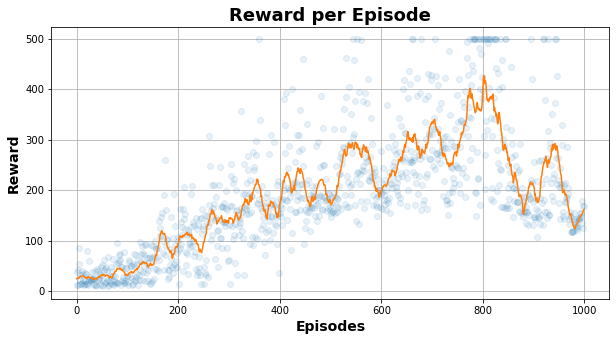

In [23]:
arr=np.array(agent.count)
x=arr[:,0]
y=arr[:,1]
y_trend=savgol_filter(y, 33, 3, mode='nearest')

plt.figure(figsize=(10,5))
plt.plot(x,y, 'o', alpha=0.1)
plt.plot(x,y_trend, '-')
plt.ylabel('Reward',fontsize=14, fontweight='bold')
plt.xlabel('Episodes',fontsize=14, fontweight='bold')
plt.title('Reward per Episode', fontsize=18, fontweight='bold')
plt.grid()
plt.show()

In [25]:
agent.load(output_dir + f"Best_Weights2.hdf5")

# View Results

In [29]:
done=False
state = env.reset() # reset state at start of each new episode of the game
state = np.reshape(state, [1, state_size])

for i in range(5000):  # length of episode. 
      
    action = agent.act(state, evalmode=True) 
    env.render()
    next_state, reward, done, _ = env.step(action) # agent interacts with env, gets feedback; 4 state data points, e.g., pole angle, cart position              
    next_state = np.reshape(next_state, [1, state_size])       
    state = next_state       
    if done: 
        print(f"Reward: {i}") 
        break # exit loop
        
env.close()    

Reward: 499


# Summary

DQN is a tool that can learn to solve the cartpole problem. A neural network with 10% dropout and four hidden layers was trained using the loss between the current state and the goal state to update the model weights. For further improvements, the agent could be reinitialized and trained at a lower learning rate. with an initial learning rate of 0.001 the learning began to plateau at 1000 episodes.  The learning rate was dropped by a factor of ten, this process could be repeated until the cart balancing score reached the preset maximum of 1,000.  This value was set by me.  it is interesting to note that the max score was 499 in all trials. Further investigation is needed to determine if this is a preset limit by the program.  it is also worth noting that cartpolev1 environment return better results than cartpolev0.   

In [30]:
print(f'Finished: {dt.datetime.now()}')

Finished: 2021-04-17 12:00:57.240428
